# Importing packages

In [28]:
# Data manipulation and math computation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data visualisation 
import matplotlib.pyplot as plt
import seaborn as sns

# ML algorithms for the classification
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics used for measuring the accuracy and performance of the models
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve

#Model tunning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Save models
import pickle

# Load the training data

In [29]:
#load the data
df = pd.read_csv("lib/data/PartitionedNetwork.csv",sep=",")
df_x = df.drop(columns=['Choice'])
df_y = df.Choice

# Derived features

In [30]:
# Create a bunch of "A-B" and 'AmA' features
def add_derived_features(df):
    minus_features = ['follower_count','listed_count']
    for col in minus_features:
        df['AmB_' + col] = df['A_'+col] - df['B_'+col]
    for cand in ['A','B']:
        df[cand + '_follower_m_following_count'] = df[cand + '_follower_count'] - df[cand + '_following_count']
    
    return df

df_x = add_derived_features(df_x)

# Model evaluation

In [31]:
# Function to evaluate the results using Accuracy and ROC AUC
def evaluate(model,x,y):
    #predict the output
    predictions = model.predict(x)
    predicting_prob = model.predict_proba(x)[:,1]
    
    #Accuracy score
    accuracy = accuracy_score(y_pred=predictions,y_true=y)
    print("Accuracy: {:.3f}% ".format(accuracy*100))
    # ROC AUC score
    roc_auc = roc_auc_score(y_score=predicting_prob,y_true=y)
    print("ROC AUC: {:.3f}% \n".format(roc_auc*100))  

# Run cross-validation
def run_cross_validation(model,name,x_tot,y_tot,cv):
    print('Starting Cross-validation')
    
    #Score using accuracy
    scoresAccuracy=cross_val_score(model,x_tot,y_tot,cv=cv,verbose=1,n_jobs=-1)
    print("CV with accuracy: %0.3f +/- %0.3f" % (scoresAccuracy.mean(), scoresAccuracy.std()))
    
    #Score with AUC
    scoresROCAUC=cross_val_score(model,x_tot,y_tot,cv=cv,scoring='roc_auc',verbose=1,n_jobs=-1)
    print("CV with ROC AUC: %0.3f +/- %0.3f" % (scoresROCAUC.mean(), scoresROCAUC.std()))
    
    #Plot learning curve 
    plot_learning_curve(model,name,x_tot,y_tot,cv=cv,n_jobs=-1)
    plt.show()
    
def advanced_evaluate_model(model,name, x_train, y_train, x_test, y_test, cv):
    # Train the algorithm
    history = model.fit(x_train,y_train)
    #predict the output
    predictions = model.predict(x_test)
    predicting_prob = model.predict_proba(x_test)[:,1]
    
    print(model)
    # Evaluate the results
    print('**********************TRAIN Sample***********************')
    evaluate(model,x_train,y_train)     
    print('***********************TEST Sample***********************')
    evaluate(model,x_test,y_test) 
    
    # Merge test and train samples
    x_tot = pd.concat([x_train,x_test],axis=0)
    y_tot = pd.concat([y_train,y_test],axis=0)

    # If run cross-validation:
    if cv:
        #Cross-validation

        # Splitting strategy
        kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=1)
    
        run_cross_validation(model,name,x_tot,y_tot,cv=kfold)
    
    # ROC Curve. 
    fpr,tpr,thresh = roc_curve(y_test,predicting_prob)
    plt.figure(figsize=(7,7))
    plt.plot(fpr,tpr,label = ("Area under the curve {:0.3f}".format(auc(fpr,tpr))),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title(name + " ROC - Curve & Area Under Curve",fontsize=18)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    
    # plot learning history:
    if name == 'DNN': 
        plot_DNN_training_history(history)
        plt.show()
    
    print('\n\n')
    
    model.fit(x_tot,y_tot)
    
    return model

# function to evaluate the feature importance
def feature_importance(df_ini,model,model_type,model_name):
    # transform the input data, accessing is different for different algorithms, hard coded now. 
    # Should be imporved later
    if model_type == 'importance':
        df = pd.DataFrame(model.feature_importances_,df_ini.columns).reset_index()
    else:
        df = pd.DataFrame(model.coef_.ravel(),df_ini.columns).reset_index()
    df.rename(columns={'index':'features',0:'coefficients'},inplace=True)
    # sort the values
    df.sort_values(by='coefficients',ascending = False,inplace=True)
        
    #plot
    sns.barplot(x = df['coefficients'] ,y = df['features'])    
    plt.title("Feature Importance " + model_name,fontsize=11,fontweight="bold")
    
def fast_feature_importance(df,models):
    df_x = df
    if 'Choice' in df.columns:
        df_x = df.drop(columns=['Choice'])
    # Analyse feature importance
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)
    for i, model in enumerate(models,start=1):
        plt.subplot(2,2,i)
        feature_importance(df_x,model.model,model.model_type,model.name)
        
# function from 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Train models

In [32]:
class MLmodel:
    def __init__(self,model,name,model_type = 'importance'):
        self.name = name
        self.model = model
        self.model_type = model_type

In [33]:
MLModels = [
    MLmodel(XGBClassifier(random_state=1,n_estimators=1000,learning_rate=0.01,max_depth=3)
            ,'XGBoost','importance'),
    MLmodel(RandomForestClassifier(n_jobs=16,n_estimators=450, random_state=1)
            ,'RF','importance')
]

In [34]:
# Columns to bo used for predictions
cols = ['AmB_listed_count','AmB_follower_count','B_network_feature_1',
        'A_follower_m_following_count','A_network_feature_1',
        'B_listed_count','A_following_count', 'B_following_count',
       ]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
**********************TRAIN Sample***********************
Accuracy: 80.729% 
ROC AUC: 89.903% 

***********************TEST Sample***********************
Accuracy: 77.350% 
ROC AUC: 87.230% 

Starting Cross-validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   39.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV with accuracy: 0.776 +/- 0.019


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   34.5s finished


CV with ROC AUC: 0.867 +/- 0.017


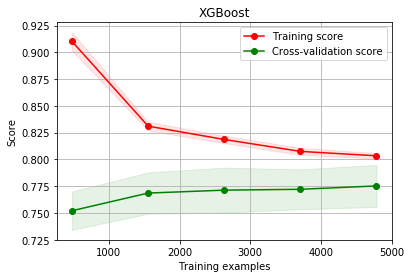

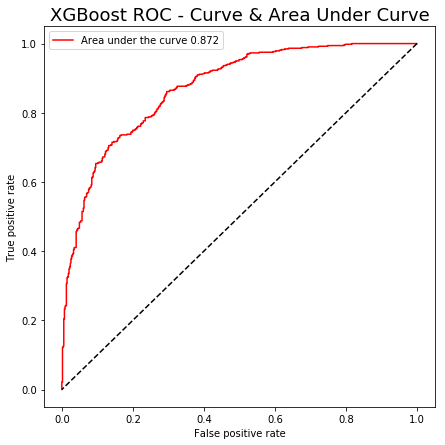




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=16,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
**********************TRAIN Sample***********************
Accuracy: 99.318% 
ROC AUC: 99.991% 

***********************TEST Sample***********************
Accuracy: 76.128% 
ROC AUC: 85.693% 

Starting Cross-validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   55.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV with accuracy: 0.759 +/- 0.021


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   53.9s finished


CV with ROC AUC: 0.849 +/- 0.018


/Users/rostyslav/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/rostyslav/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/rostyslav/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/rostyslav/anaconda3/lib/python3.6/site-packages/sklearn/externa

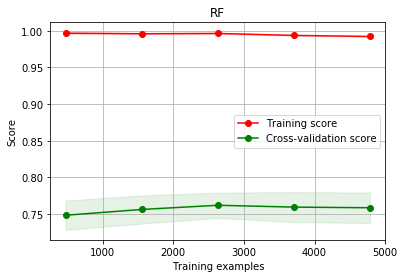

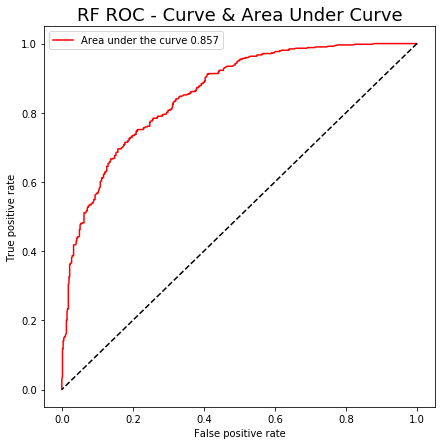

In [40]:
model_res = {}
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(df_x[cols], df_y, test_size=0.2, random_state=1)
for model in MLModels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train_t,y_train_t,x_test_t,y_test_t,True)

# Tune models

## XGBoost

In [36]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

In [37]:
# which booster to use
booster = ['gbtree']
# eta - learning_rate
learning_rate = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 10)]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1100, num = 20)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate' : learning_rate,
               'booster': booster}

print(random_grid)

{'n_estimators': [200, 247, 294, 342, 389, 436, 484, 531, 578, 626, 673, 721, 768, 815, 863, 910, 957, 1005, 1052, 1100], 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 20], 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55], 'booster': ['gbtree']}


In [19]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 500, cv = 2, verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
xgb_random.fit(x_train_t, y_train_t)
print('BEST RANDOM:')
evaluate(xgb_random,x_test_t,y_test_t)
print('BEST Parameters: {}'.format(xgb_random.best_params_))

Fitting 2 folds for each of 500 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.1min finished


BEST RANDOM:
Accuracy: 77.914% 
ROC AUC: 87.128% 

BEST Parameters: {'n_estimators': 910, 'max_depth': 1, 'learning_rate': 0.3, 'booster': 'gbtree'}


In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 14, 18, 19, 20,21, 22, 25, 29],
    'max_features': [2, 3],
    'min_samples_leaf': [1,2,3, 4],
    'min_samples_split': [3,4,5,6,7],
    'n_estimators': [450,500,550,575,600,625,650,675,700]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)